<a href="https://colab.research.google.com/github/PetrovES570/PDA_SOL/blob/main/5_%D0%A0%D0%B0%D0%B7%D0%B2%D0%B5%D0%B4%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_PySpark_%D0%9F%D0%B5%D1%82%D1%80%D0%BE%D0%B2_%D0%95%D0%B2%D0%B3%D0%B5%D0%BD%D0%B8%D0%B9_%D0%91%D0%94_231%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа 5. Разведочный анализ данных с помощью PySpark
Выполнил - Петров Евгений. БД 231м

Данные для анализа взяты из kaggle.com

---


Название датасета - Cyber Security Attacks

---

Ссылка на датасет - https://www.kaggle.com/datasets/teamincribo/cyber-security-attacks

# **1. Инициализация платформы Spark и загрузка данных в фрейм данных Spark**



In [74]:

import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4b2b70f20e43f433b30689c85879f432cdbb3e981ab51055f57aa54368c19adc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [7]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, count, sum, min, max
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '/content/cybersecurity_attacks.csv' # Загрузите данные в текущий каталог Colab.

df = spark.read.option("header", True).csv(filename_data)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Обзор набора данных** <a class="anchor" id="2"></a>

### Схема, столбцы и типы данных набора:
   *Набор данных содержит как столбцы с одним значением (int, string), так и столбцы, состоящие из списка массивов.*

In [8]:
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- Timestamp: string (nullable = true)
 |-- Source IP Address: string (nullable = true)
 |-- Destination IP Address: string (nullable = true)
 |-- Source Port: string (nullable = true)
 |-- Destination Port: string (nullable = true)
 |-- Protocol: string (nullable = true)
 |-- Packet Length: string (nullable = true)
 |-- Packet Type: string (nullable = true)
 |-- Traffic Type: string (nullable = true)
 |-- Payload Data: string (nullable = true)
 |-- Malware Indicators: string (nullable = true)
 |-- Anomaly Scores: string (nullable = true)
 |-- Alerts/Warnings: string (nullable = true)
 |-- Attack Type: string (nullable = true)
 |-- Attack Signature: string (nullable = true)
 |-- Action Taken: string (nullable = true)
 |-- Severity Level: string (nullable = true)
 |-- User Information: string (nullable = true)
 |-- Device Information: string (nullable = true)
 |-- Network Segment: string (nullable = true)
 |-- Geo-location Data: string (nullable = true)
 |-- Proxy In

,Column Name,Data type
0,Timestamp,string
1,Source IP Address,string
2,Destination IP Address,string
3,Source Port,string
4,Destination Port,string
5,Protocol,string
6,Packet Length,string
7,Packet Type,string
8,Traffic Type,string
9,Payload Data,string


In [17]:
print(f'Общее количество {df.count()} строк, печатаем несколько первых строк:')
df.limit(2).toPandas()

Общее количество 59366 строк, печатаем несколько первых строк:


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,None,None,None,None,None,None,None,None,None,None
1,Maiores possimus ipsum saepe vitae. Ad possimu...,IoC Detected,28.67,None,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,...,Server,None,None,None,None,None,None,None,None,None


# **3. Исследовательский анализ.** <a class="anchor" id="3"></a>





Основные статистические показатели

In [18]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df.describe().toPandas()

Описание фрейма данных (только строковые и числовые столбцы):


,summary,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,count,59366,48944,57826,48914,57826,57826,57826,57826,57826,...,40000,22174,22174,22174,22174,22174,11097,11113,10951,22174
1,mean,None,None,50.04583080893084,32970.35645,33150.86865,None,781.452725,None,None,...,None,None,None,None,None,None,None,None,None,None
2,stddev,None,None,28.780200765128598,18560.425604487325,18574.668841565173,None,416.04419186465515,None,None,...,None,None,None,None,None,None,None,None,None,None
3,min,2020-01-01 00:43:27,1.1.45.194,0.0,10000,10002,ICMP,100,Control,Aaina Ahluwalia,...,Blocked,High,Aaina Arya,Mozilla/5.0 (Android 1.0; Mobile; rv:14.0) Gec...,Segment A,"Adoni, Andhra Pradesh",1.103.79.225,Log Data,Alert Data,Firewall
4,max,Voluptatum voluptates dolore doloribus in vero...,IoC Detected,99.99,Alert Triggered,Malware,UDP,Logged,Medium,Zoya Venkatesh,...,Server,Medium,Zoya Yohannan,Opera/9.99.(X11; Linux x86_64; ti-ER) Presto/2...,Segment C,"Yamunanagar, West Bengal",99.92.154.17,Log Data,Alert Data,Server


После предварительного просмотра столбцов первое, что должны проверить, — это наличие в наборе данных какого-либо пропущенного значения.
– Для строковых столбцов  проверяем наличие `None` и `null`.
- Для числовых столбцов проверяем наличие нулей и `NaN`.
- Для столбцов типа массив проверяем, содержит ли массив нули или `NaN`.

In [45]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,Timestamp,string
1,Source IP Address,string
2,Destination IP Address,string
3,Source Port,string
4,Destination Port,string
5,Protocol,string
6,Packet Length,string
7,Packet Type,string
8,Traffic Type,string
9,Payload Data,string


In [46]:
string_columns = ['Timestamp', 'Protocol', 'Packet Type', 'Traffic Type', 'Action Taken', 'Severity Level', 'Log Source', 'Payload Data', 'Malware Indicators', 'Anomaly Scores', 'Alerts/Warnings', 'Attack Type', 'Attack Signature', 'User Information', 'Device Information', 'Network Segment', 'Geo-location Data', 'Proxy Information','Firewall Logs', 'IDS/IPS Alerts','Log Source']
numeric_columns = ['Source IP Address', 'Destination IP Address', 'Source Port', 'Packet Length', 'Proxy Information']
array_columns = []
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,Timestamp,Source IP Address,Destination IP Address,Source Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,0,0,0,0,1540,0,1540,1540,1540,30484,...,19366,37192,37192,37192,37192,37192,0,48253,48415,37192


In [47]:
# Преобразование во временном значении дня
def to_datetime(t):
    return datetime.strptime(t, "%Y-%m-%d %H:%M:%S")

# Используем вспомогательную функцию PySpark
udf_to_datetime = udf(to_datetime, TimestampType())
df

DataFrame[Timestamp: string, Source IP Address: string, Destination IP Address: string, Source Port: string, Destination Port: string, Protocol: string, Packet Length: string, Packet Type: string, Traffic Type: string, Payload Data: string, Malware Indicators: string, Anomaly Scores: string, Alerts/Warnings: string, Attack Type: string, Attack Signature: string, Action Taken: string, Severity Level: string, User Information: string, Device Information: string, Network Segment: string, Geo-location Data: string, Proxy Information: string, Firewall Logs: string, IDS/IPS Alerts: string, Log Source: string, Datetime: int, DAY: int]

In [48]:
def to_day(t):
    return datetime.strptime(t, "%Y-%m-%d %H:%M:%S").day
udf_to_day = udf(to_day, IntegerType())

In [75]:
df = df.withColumn('Datetime',
    udf_to_day(df.Timestamp))
df = df.withColumn('DAY',
    udf_to_day(df.Timestamp))
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,Timestamp,string
1,Source IP Address,string
2,Destination IP Address,string
3,Source Port,string
4,Destination Port,string
5,Protocol,string
6,Packet Length,string
7,Packet Type,string
8,Traffic Type,string
9,Payload Data,string


Проанализируем количество атак DDOS в разрезе по дням

In [69]:
LAUND_DF = df \
    .select(df.DAY, df.Timestamp) \
    .filter(df['Attack type'] == 'DDoS') \
    .distinct() \
    .groupBy(df.DAY) \
    .agg(count('Timestamp').alias('cnt')).toPandas()

In [70]:
LAUND_DF = LAUND_DF.set_index('DAY').sort_index()
LAUND_DF

,cnt
DAY,
1,245
2,241
3,226
4,237
5,247
6,236
7,237
8,238
9,265


[Text(0.5, 1.0, 'Количество DDoS атак за месяц'),
 Text(0.5, 0, 'День'),
 Text(0, 0.5, 'Количество атак')]

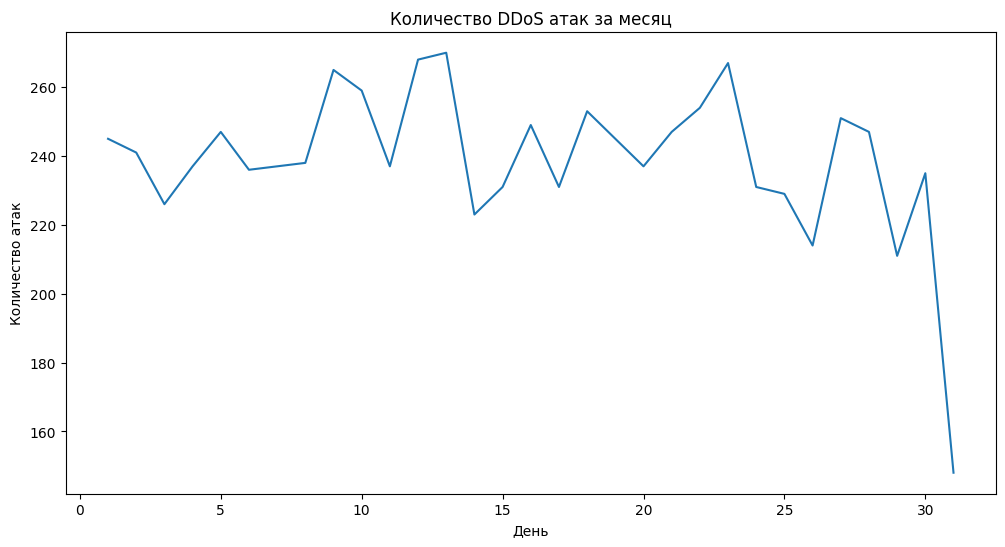

In [77]:
# изменим размер графика, уберем легенду и добавим подписи
ax = LAUND_DF.plot(figsize = (12,6), legend = None)
ax.set(title = 'Количество DDoS атак за месяц', xlabel = 'День', ylabel = 'Количество атак')


Количество атак с помощью вирусов за месяц, **'Attack type'** - Malware

[Text(0.5, 1.0, 'Количество атак с помощью вирусов'),
 Text(0.5, 0, 'День'),
 Text(0, 0.5, 'Количество атак')]

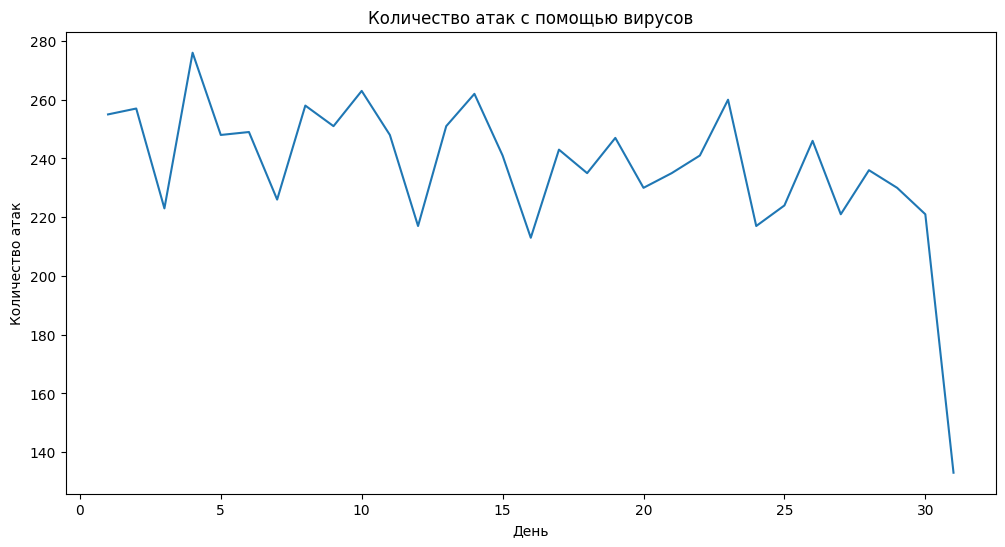

In [78]:
NOLAUND_DF = df \
    .select(df.DAY, df.Timestamp) \
    .filter(df['Attack type'] == 'Malware') \
    .distinct() \
    .groupBy(df.DAY) \
    .agg(count('Timestamp').alias('cnt')).toPandas()

NOLAUND_DF = NOLAUND_DF.set_index('DAY').sort_index()
ax = NOLAUND_DF.plot(figsize = (12,6), legend = None)
ax.set(title = 'Количество атак с помощью вирусов за месяц', xlabel = 'День', ylabel = 'Количество атак')